# Cell2Fate analysis of human bone marrow dataset

In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
data_name = 'HumanBoneMarrow'

Global seed set to 0


In [2]:
# Where to get data from and where to save results (you need to modify this)
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/HumanBoneMarrow/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/HumanBoneMarrow/'

In [3]:
# # Downloading data into specified directory:
# os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

0

Load the data and extract most variable genes (and optionally remove some clusters).

In [3]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 100000 cells per cluster
Filtered out 7837 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


In [4]:
max_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


2023-07-24 12:23:49.796307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc-8.2.0/lib64/
2023-07-24 12:23:49.796778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc-8.2.0/lib64/
2023-07-24 12:23:49.796802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Number of Leiden Clusters: 10
Maximal Number of Modules: 11


Overview of the dataset on a UMAP, coloured by cluster assingment.

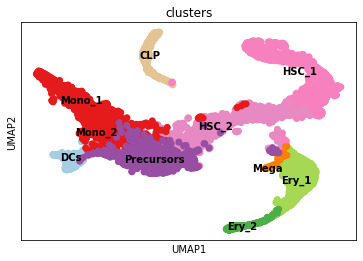

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

As usual in the scvi-tools workflow we register the anndata object ...

In [6]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

... and initialize the model:

In [7]:
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = max_modules, Tmax_prior={"mean": 500., "sd": 100.})

Let's have a look at the anndata setup:

In [8]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 5780  │
│      n_vars      │ 3000  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

Training the model:

In [9]:
mod.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [13:00<00:00,  1.56s/it, v_num=1, elbo_train=1.63e+7]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

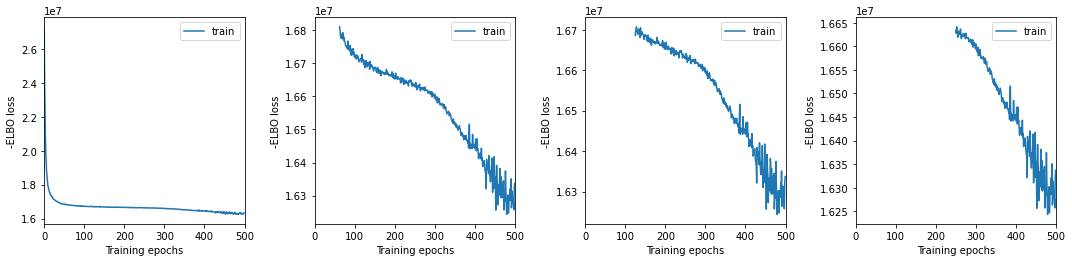

In [10]:
mod.view_history()

Here we export the model posterior to the anndata object:

In [11]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 5780
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

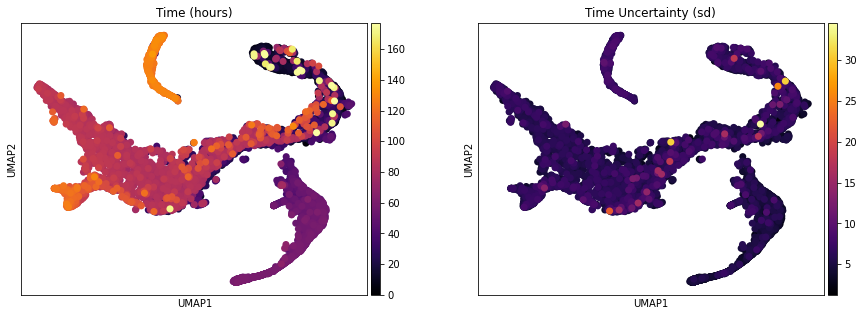

In [12]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

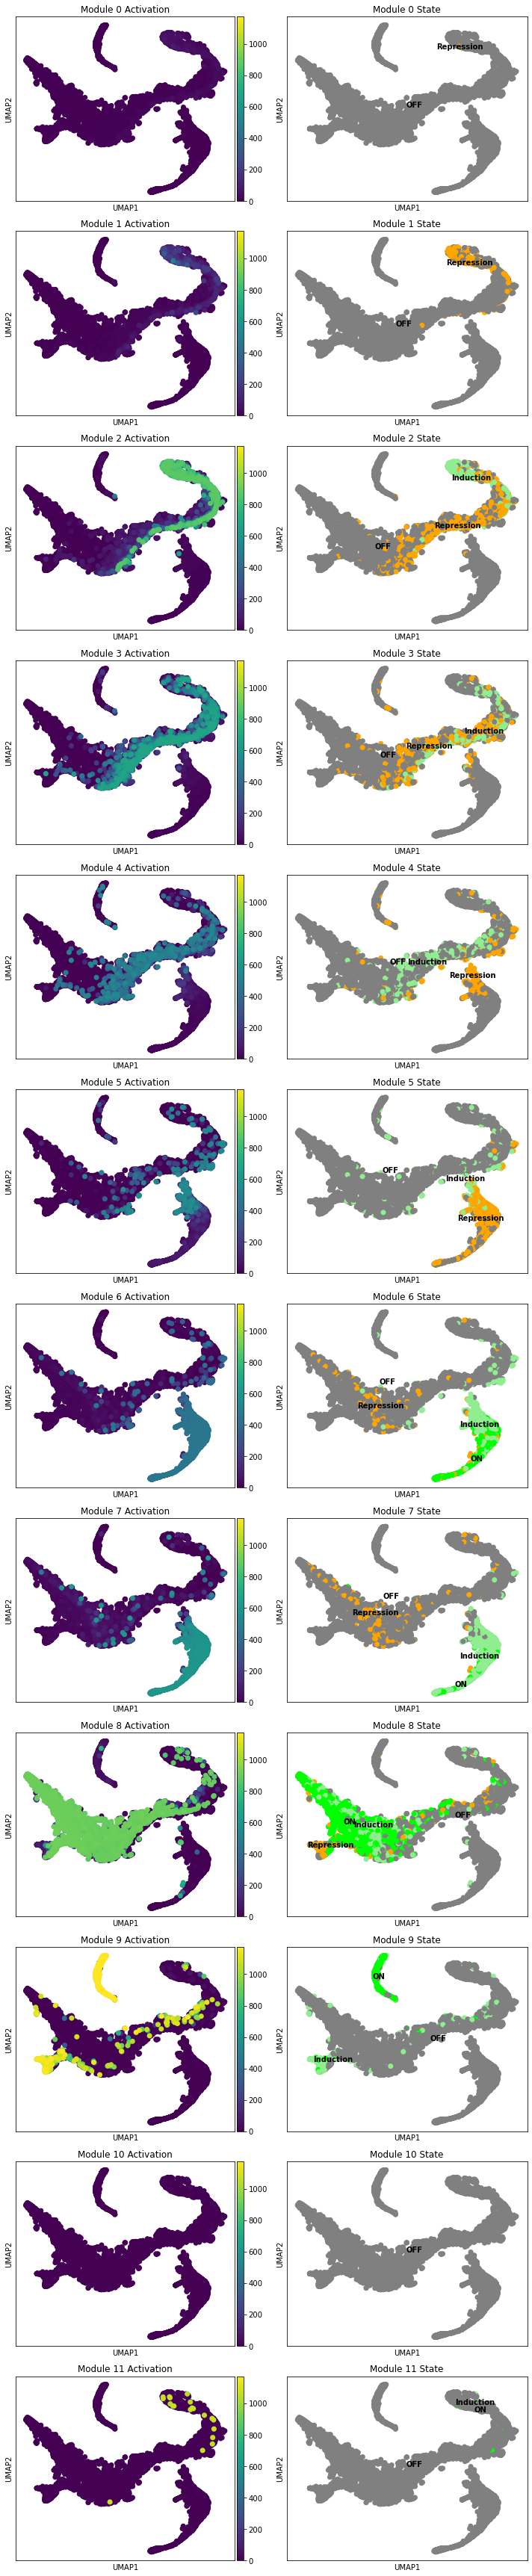

In [13]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

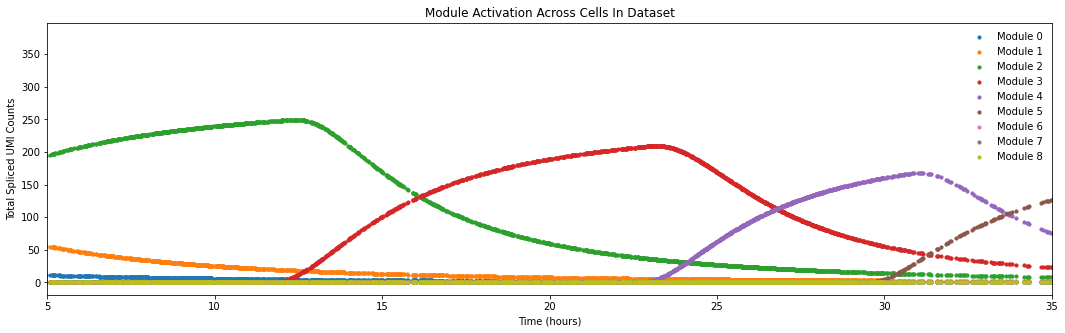

In [14]:
mod.compare_module_activation(adata, chosen_modules = [0,1,2,3,4,5,6,7,8], time_max = 35, time_min = 5,
                         save = results_path + data_name + 'module_activation_comparison.pdf')

It is also possible to visualize "module-specific" velocity although this does not always work well:

In [15]:
# mod.compute_and_plot_module_velocity(adata, save = results_path + data_name + 'module_velocity_plots.png')

And of course we can make the usual visualization of total RNAvelocity on a UMAP:

Computing total RNAvelocity ...


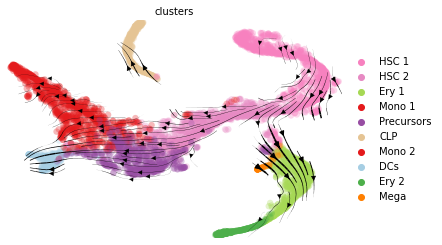

In [16]:
mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png')

To make the plot look the same in style as the scvleo plots:

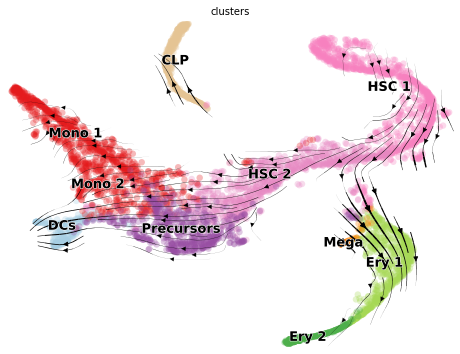

In [17]:
import scvelo as scv
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax, legend_fontsize = 13)
plt.savefig(results_path + data_name + 'total_velocity_plots.png')

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

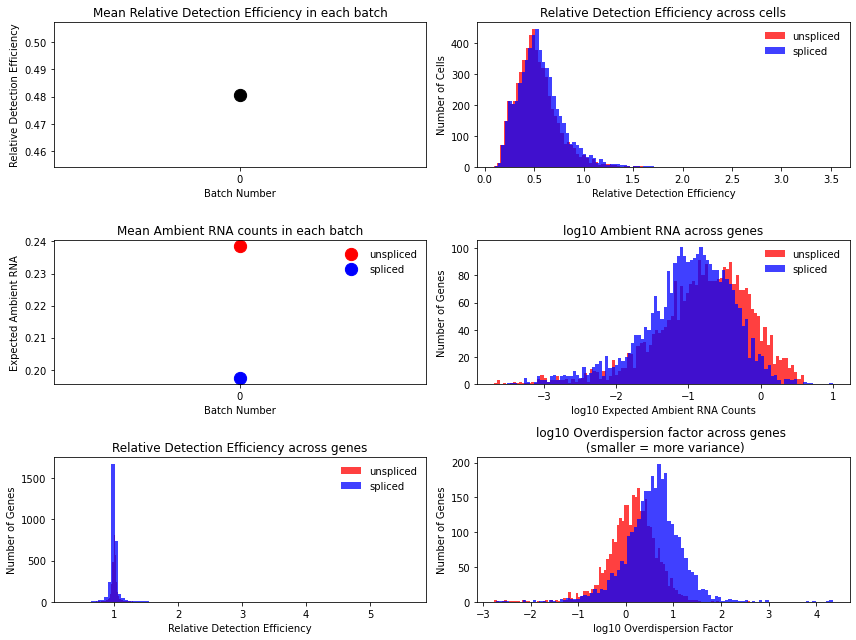

In [18]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [19]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.06870775
gamma_g mean: 0.8181456
beta_g mean: 0.7405973
lam_mi, all modules: 
 
 [[[3.4  2.61]]

 [[2.24 2.46]]

 [[2.21 2.39]]

 [[2.13 1.65]]

 [[3.1  2.54]]

 [[3.72 3.58]]

 [[3.55 4.18]]

 [[3.35 2.35]]

 [[2.65 1.77]]

 [[2.59 2.44]]

 [[2.77 2.75]]

 [[4.63 3.51]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [20]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"GPC5, DYTN, SNED1, CRHBP, PRKG1, CHRM3, MAGI2,...",,
1,1,"RORA, RP11-1I2.1, PDZRN4, EPB41L4A-AS1, RARRES...",,
2,2,"SLC39A6, HLF, PHLDB2, LIMCH1, EMCN, RP11-475O6...",,
3,3,"LIPE, MYO1G, STAMBPL1, PXN, RXFP1, TMEM106A, L...",,
4,4,"FAT3, PARP14, SLA2, DDX60, CEP85L, STAP1, ZC4H...",,
5,5,"VCL, PIEZO2, IKZF2, ARHGAP6, FCER1A, AOAH, WFD...",,"platelet degranulation (GO:0002576), regulated..."
6,6,"STXBP6, NR1H2, BTK, PEF1, MPST, NCF4, SNRPN, N...",,
7,7,"NMU, FAM178B, TNFAIP6, CA1, SUCLG2, ANK1, PPAR...",,
8,8,"CSTA, MNDA, AZU1, CTSG, EGR1, SERPINB10, GRN, ...",,"neutrophil degranulation (GO:0043312), neutrop..."
9,9,"RP11-524N5.1, LINC01013, AKAP12, SCT, HMHB1, L...",,


Reprocessing adata.X, set process = False if this is not desired.


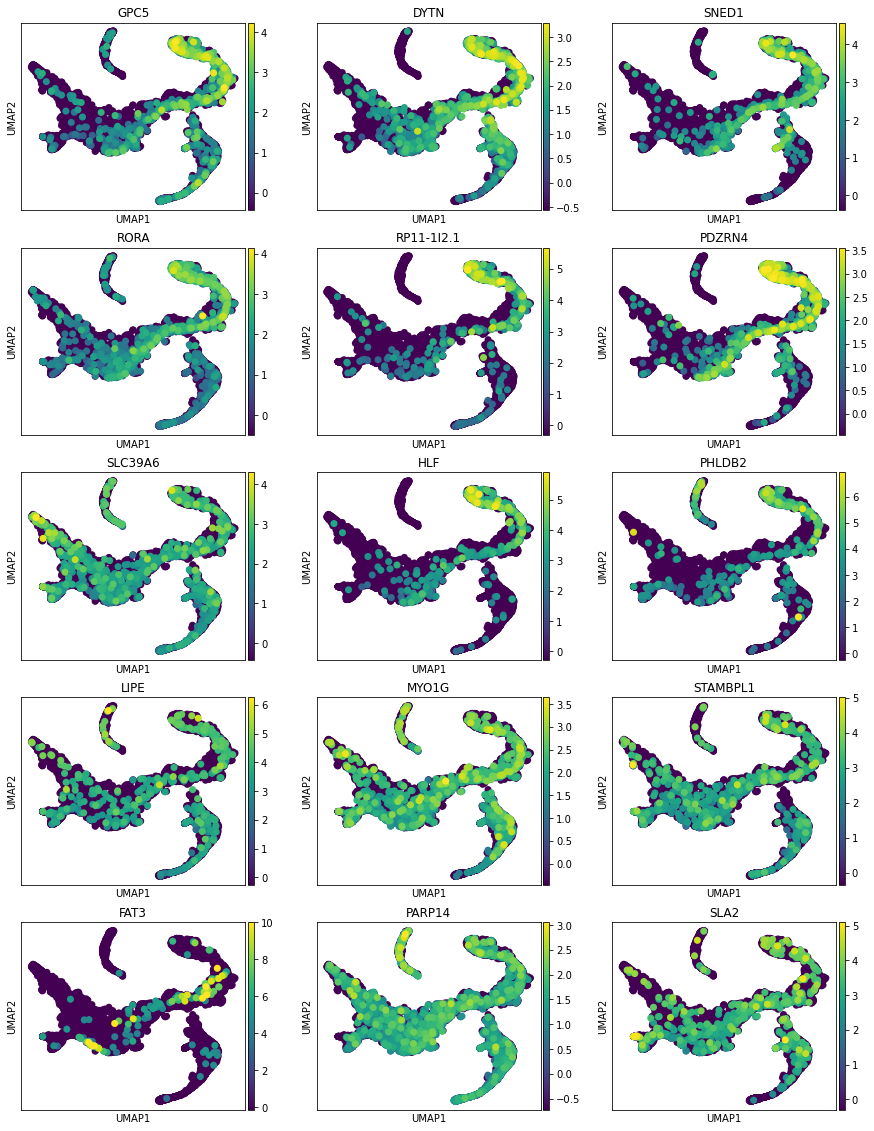

In [21]:
mod.plot_top_features(adata, tab, chosen_modules = [0,1,2,3,4], mode = 'all genes', n_top_features = 3, process = True)